In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn import metrics

import seaborn as sns

Using TensorFlow backend.


In [2]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

test = test.drop(test.columns[0], axis=1)
all_data = pd.concat([train, test])

/Users/mayuanchao/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
all_data

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0
1,D'aww! He matches this background colour I'm s...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0
2,"Hey man, I'm really not trying to edit war. It...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0
3,"""\nMore\nI can't make any real suggestions on ...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0
4,"You, sir, are my hero. Any chance you remember...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0
5,"""\n\nCongratulations from me as well, use the ...",00025465d4725e87,0.0,0.0,0.0,0.0,0.0,0.0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,0002bcb3da6cb337,0.0,1.0,1.0,1.0,0.0,1.0
7,Your vandalism to the Matt Shirvington article...,00031b1e95af7921,0.0,0.0,0.0,0.0,0.0,0.0
8,Sorry if the word 'nonsense' was offensive to ...,00037261f536c51d,0.0,0.0,0.0,0.0,0.0,0.0
9,alignment on this subject and which are contra...,00040093b2687caa,0.0,0.0,0.0,0.0,0.0,0.0


Total comments  312735
Total clean comments  302176
Total tags  identity_hate    1405.0
insult           7877.0
obscene          8449.0
severe_toxic     1595.0
threat            478.0
dtype: float64


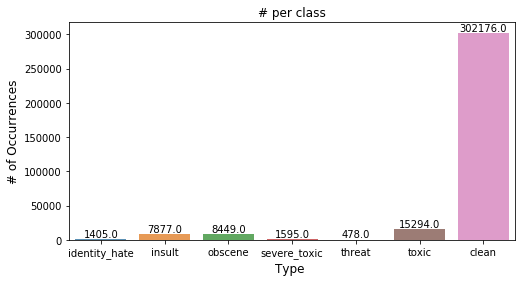

In [4]:
# Data visualizations
# Total clean comments

#marking comments without any tags as "clean"
rowsums = all_data.iloc[:,2:7].sum(axis=1)
all_data['clean'] = np.logical_not(rowsums).astype('int')

x = all_data.iloc[:,2:].sum()

#count number of clean entries
print("Total comments ", len(all_data))
print("Total clean comments ", all_data['clean'].sum())
print("Total tags ", all_data.iloc[:,2:7].sum())

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


The above visualization clear shows that there is a class imbalance. Even among the toxic types.

In [5]:
# check for nulls
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, comment_text    False
 dtype: bool)

In [6]:
# split data by class
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
#y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]


In [7]:
# tokenize strings
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [8]:
# pad tokens
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [32]:
# visualize word distribution
#totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
totalNumWords = [len(set(one_comment)) for one_comment in list_tokenized_train]

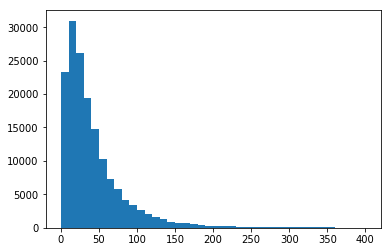

In [33]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [35]:
len([length for length in totalNumWords if length<=100])/len(totalNumWords)

0.9144518740873968